In [1]:
import pandas
import datetime
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score,KFold,cross_validate,train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz,DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier,RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier  
from sklearn.cluster import KMeans
from datetime import datetime
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
# from catboost import CatBoostClassifier

from tqdm import tqdm_notebook
import eli5

In [3]:
def uplift_fit_predict(model, X_train, treatment_train, target_train, X_test):
    """
    Реализация простого способа построения uplift-модели.
    
    Обучаем два бинарных классификатора, которые оценивают вероятность target для клиента:
    1. с которым была произведена коммуникация (treatment=1)
    2. с которым не было коммуникации (treatment=0)
    
    В качестве оценки uplift для нового клиента берется разница оценок вероятностей:
    Predicted Uplift = P(target|treatment=1) - P(target|treatment=0)
    """
    X_treatment, y_treatment = X_train[treatment_train == 1, :], target_train[treatment_train == 1]
    X_control, y_control = X_train[treatment_train == 0, :], target_train[treatment_train == 0]
    model_treatment = clone(model).fit(X_treatment, y_treatment)
    model_control = clone(model).fit(X_control, y_control)
    predict_treatment = model_treatment.predict_proba(X_test)[:, 1]
    predict_control = model_control.predict_proba(X_test)[:, 1]
    predict_uplift = predict_treatment - predict_control
    return predict_uplift


def uplift_score(prediction, treatment, target, rate=0.3):
    """
    Подсчет Uplift Score
    """
    order = np.argsort(-prediction)
    treatment_n = int((treatment == 1).sum() * rate)
    treatment_p = target[order][treatment[order] == 1][:treatment_n].mean()
    control_n = int((treatment == 0).sum() * rate)
    control_p = target[order][treatment[order] == 0][:control_n].mean()
    score = treatment_p - control_p
    return score


# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [29]:
# Чтение данных
df_clients = pandas.read_csv('data/clients.csv', index_col='client_id')
# df_clients = reduce_mem_usage(df_clients)
df_train = pandas.read_csv('data/uplift_train.csv', index_col='client_id')
df_train = reduce_mem_usage(df_train)
df_test = pandas.read_csv('data/uplift_test.csv', index_col='client_id')
df_test = reduce_mem_usage(df_test)
df_products = pandas.read_csv('data/products.csv', index_col='product_id')
df_products = reduce_mem_usage(df_products)

Memory usage of dataframe is 4.58 MB
Memory usage after optimization is: 1.91 MB
Decreased by 58.3%
Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 1.53 MB
Decreased by 0.0%
Memory usage of dataframe is 3.61 MB
Memory usage after optimization is: 1.58 MB
Decreased by 56.3%


In [33]:
df_purchases = pandas.read_csv('data/purchases.csv', nrows=4000000)
df_purchases = reduce_mem_usage(df_purchases)

Memory usage of dataframe is 396.73 MB
Memory usage after optimization is: 244.86 MB
Decreased by 38.3%


In [67]:
df_purchases.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


In [34]:
def predict(df_features, model=GradientBoostingClassifier(),print_score=False,make_sibmition=False, filename='submission'):
    
    indices_train = df_train.index
    indices_test = df_test.index
    indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

    valid_uplift = uplift_fit_predict(
        model=model,
        X_train=df_features.loc[indices_learn, :].fillna(0).values,
        treatment_train=df_train.loc[indices_learn, 'treatment_flg'].values,
        target_train=df_train.loc[indices_learn, 'target'].values,
        X_test=df_features.loc[indices_valid, :].fillna(0).values,
    )
    # Оценка качества на валидации

    if print_score:
        valid_score = uplift_score(valid_uplift,
        treatment=df_train.loc[indices_valid, 'treatment_flg'].values,
        target=df_train.loc[indices_valid, 'target'].values,
        )
        print('Validation score:', valid_score)
    if make_sibmition:
        test_uplift = uplift_fit_predict(
        model=model,
        X_train=df_features.loc[indices_train, :].fillna(0).values,
        treatment_train=df_train.loc[indices_train, 'treatment_flg'].values,
        target_train=df_train.loc[indices_train, 'target'].values,
        X_test=df_features.loc[indices_test, :].fillna(0).values,
        )

        df_submission = pandas.DataFrame({'uplift': test_uplift}, index=df_test.index)
        now = str(datetime.now()).replace(' ','-')[:13]
        df_submission.to_csv(filename + now + '.csv')

'transaction_id' соотвествует единственная стоимость 'purchase_sum';

'transaction_id' привязана к магазину 'store_id'

In [7]:
# d = {}
# for t in df_purchases.client_id.unique():
#     l = []
#     temp = df_purchases[df_purchases.client_id == t]
#     for tranc in temp.transaction_id.unique():
#     #     print(tranc)
#         l.append(temp[temp.transaction_id == tranc]['purchase_sum'].unique()[0])
#     #     print('*'*20)
#     d[t] = np.mean(l)
# import seaborn as sns
# sns.distplot(list(d.values()))

In [35]:
# Извлечение признаков

df_clients['first_issue_unixtime'] = pandas.to_datetime(df_clients['first_issue_date']).astype(int)/10**9
df_clients['first_redeem_unixtime'] = pandas.to_datetime(df_clients['first_redeem_date']).astype(int)/10**9
df_features = pandas.DataFrame({
    'gender_M': (df_clients['gender'] == 'M').astype(int),
    'gender_F': (df_clients['gender'] == 'F').astype(int),
    'gender_U': (df_clients['gender'] == 'U').astype(int),
    'age': df_clients['age'],
    'first_issue_time': df_clients['first_issue_unixtime'],
    'first_redeem_time': df_clients['first_redeem_unixtime'],
    'issue_redeem_delay': df_clients['first_redeem_unixtime'] - df_clients['first_issue_unixtime'],
}).fillna(0)

In [36]:
def make_feats(group, index=df_features.index):
    funs = ['mean','max','min','std']
    ser = pandas.DataFrame(index=index)
    for f in funs:
        ser = ser.join(group.agg(f).fillna(0).astype(int), lsuffix=f'_{f}',rsuffix=f'_{f}')
    return ser

In [37]:
cols = df_features.columns

# кол-во покупок
df_features = df_features.join(df_purchases.client_id.value_counts().rename('count_all_purschases'))

#кол-во уникальных магазинов клиента
df_features = df_features.join(df_purchases.groupby(['client_id'])['store_id'].nunique().rename('count_all_stores'))

# средняя, max, min u std цена покупок
temp = df_purchases.groupby(['client_id','transaction_id']).purchase_sum.mean().rename('purch_sum_').groupby('client_id')
df_features = df_features.join(make_feats(temp))

# среднее, max, min u std кол-во уникальных продуктов в разных магазинах
temp = df_purchases.groupby(['client_id','store_id'])['product_id'].nunique().rename('product_uni_').groupby('client_id')
df_features = df_features.join(make_feats(temp))

#среднее, max, min u std кол-во товаров  за 1 покупку (транзакцию)
temp = df_purchases.groupby(['client_id','transaction_id'])['product_quantity'].sum().rename('product_quant_').groupby(['client_id'])
df_features = df_features.join(make_feats(temp))

# признаки трат и сбора экспрес и регулряный баллов по каждой транзакции
# средняя, max, min u std цена покупок
temp = df_purchases.groupby(['client_id','transaction_id']).regular_points_received.mean().rename('reg_rec').groupby('client_id')
df_features = df_features.join(make_feats(temp))

# средняя, max, min u std цена покупок
temp = df_purchases.groupby(['client_id','transaction_id']).express_points_received.mean().rename('exp_rec_').groupby('client_id')
df_features = df_features.join(make_feats(temp))

# средняя, max, min u std цена покупок
temp = df_purchases.groupby(['client_id','transaction_id']).regular_points_spent.mean().rename('reg_spent').groupby('client_id')
df_features = df_features.join(make_feats(temp))

# средняя, max, min u std цена покупок
temp = df_purchases.groupby(['client_id','transaction_id']).express_points_spent.mean().rename('exp_spent').groupby('client_id')
df_features = df_features.join(make_feats(temp))

# среднее, max, min u std кол-во уникальных продуктов за транзакцию
temp = df_purchases.groupby(['client_id','transaction_id'])['product_id'].nunique().rename('uniq_prod_by_trunc_').groupby('client_id')
df_features = df_features.join(make_feats(temp))

temp = df_purchases.groupby(['client_id','transaction_id'])['trn_sum_from_iss'].mean().rename('trn_sum_from_iss_').groupby('client_id')
df_features = df_features.join(make_feats(temp))

temp = df_purchases.groupby(['client_id','transaction_id'])['trn_sum_from_red'].mean().rename('trn_sum_from_red_').groupby('client_id')
df_features = df_features.join(make_feats(temp))


In [68]:
df_features.head()

,gender_M,gender_F,gender_U,age,first_issue_time,first_redeem_time,issue_redeem_delay,count_all_purschases,count_all_stores,purch_sum__max,...,trn_sum_from_red__max,trn_sum_from_red__std,trn_sum_from_red__std,first_issue_day,first_issue_month,first_issue_year,first_redeem_day,first_redeem_month,first_redeem_year,count
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0,0,1,45,1.501948e+09,1.515094e+09,1.314656e+07,52.0,3.0,700.0,...,0.0,0.0,0.0,5,8,2017,4.0,1.0,2018.0,2.0
000036f903,0,1,0,72,1.491832e+09,1.492951e+09,1.118613e+06,162.0,5.0,306.0,...,0.0,0.0,0.0,10,4,2017,23.0,4.0,2017.0,8.0
000048b7a6,0,1,0,68,1.544881e+09,-9.223372e+09,-1.076825e+10,56.0,2.0,471.0,...,0.0,0.0,0.0,15,12,2018,NaN,NaN,NaN,3.0
000073194a,0,1,0,60,1.495544e+09,1.511522e+09,1.597811e+07,82.0,1.0,564.0,...,21.0,21.0,0.0,23,5,2017,24.0,11.0,2017.0,6.0
00007c7133,0,0,1,67,1.495470e+09,1.546277e+09,5.080682e+07,83.0,2.0,610.0,...,78.0,78.0,0.0,22,5,2017,31.0,12.0,2018.0,5.0


In [69]:
df_features.shape

(400162, 56)

In [70]:
df_train.shape

(200039, 2)

In [71]:
df_test.shape

(200123, 0)

In [13]:
df_purchases.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


transaction_id привязаны (соотвествуют) к regular_points_received и всем признакам с поинтами

In [ ]:
sns.distplot(list(df_purchases.regular_points_received.values))

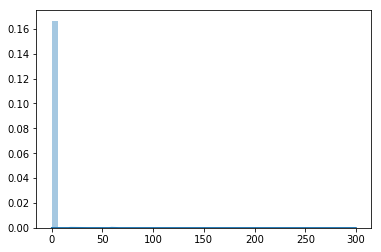

In [221]:
sns.distplot(list(df_purchases.express_points_received.values))

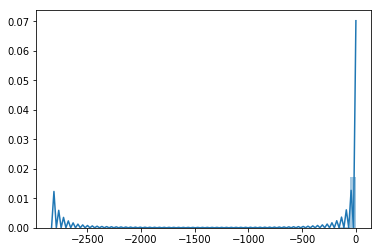

In [222]:
sns.distplot(list(df_purchases.regular_points_spent.values))

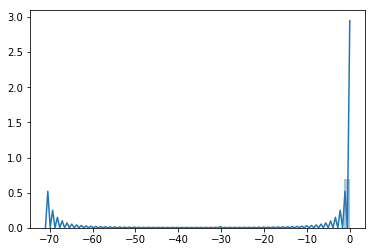

In [223]:
sns.distplot(list(df_purchases.express_points_spent.values))

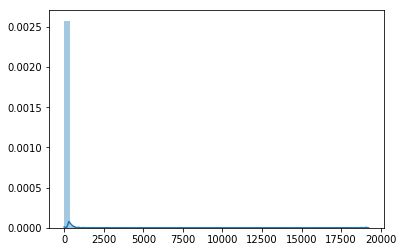

In [224]:
sns.distplot(list(df_purchases.trn_sum_from_iss.values))

In [178]:
# # Spot Check Algorithms
# models = []
# models.append(('LC', LogisticRegression()))
# models.append(('AdaBoostClassifier', AdaBoostClassifier()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('RandomForest', RandomForestClassifier()))
# models.append(('GB' ,GradientBoostingClassifier()))
# models.append(('LGBM',LGBMClassifier()))
# models.append(('XGB', XGBClassifier()))
# models.append(('CatBoost', CatBoostClassifier()))

# for name, model in models:
#     print(name)
#     if name != 'CatBoost':
# #         kfold = KFold(n_splits=5, random_state=17)
#         predict(df_features, model=model, print_score=True)
#         print('*'*20)
#     else:
#         predict(df_features, model=model, print_score=True)
#         print('*'*20)

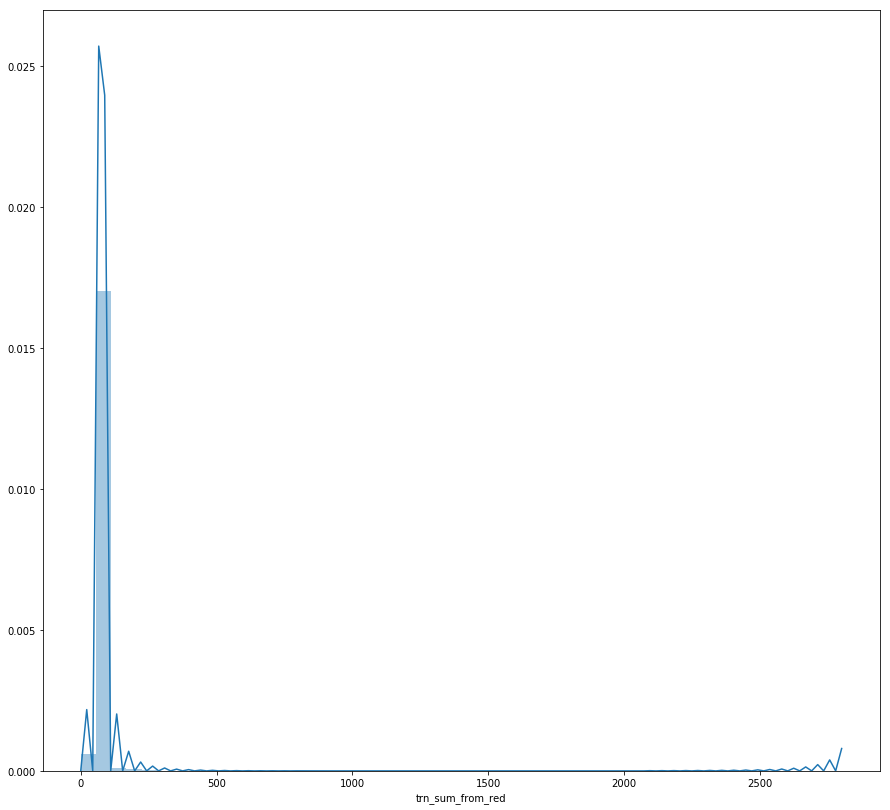

In [26]:
plt.figure(figsize=[15,14])
sns.distplot(df_purchases.trn_sum_from_red.fillna(df_purchases.trn_sum_from_red.mean()))

In [75]:
# def get_diff_from_time_sequence(df,time_col='transaction_datetime',list_cols_for_count_diff=[]):
#     l = {}
#     l2 = {}# словарь средних разниц элементов во времени 
#     cli_uni = df.client_id.unique()
#     for cli in tqdm_notebook(cli_uni):
# #         print(cli)
#         client_df = df[df.client_id == cli].sort_values(by=time_col).drop_duplicates(subset=time_col)
# #         client_df = client_df[round(client_df.shape[0]*0.3):]
#         if not list_cols_for_count_diff:
#             print('there are no columns for count')
#             return 0
#         else:
#             for col in list_cols_for_count_diff:
# #                 if client_df[col].nunique() < 2:
# #                     client_df = client_d
#                 diff = client_df[col].diff()
#                 mean_by_col = round(diff.fillna(diff.mean()).mean(),1)
#                 l[col] = mean_by_col
# #                 print(mean_by_col)
#         l2[cli] = l
#     return l2
# #                 diffs_ser = pandas.Series(clietn_df.regular_points_received.unique()).diff()
# #                 diff_day  = (pandas.to_datetime(clietn_df[time_col]).drop_duplicates(
# #                 ) - pandas.to_datetime(clietn_df[time_col]).drop_duplicates().shift()).mean().days
# #                 me = diffs_ser.fillna(diffs_ser.mean()).mean()

# #         else:
            
# #             break

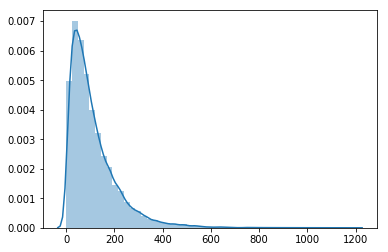

In [50]:
sns.distplot(list(df_purchases.groupby('client_id').size().values))

In [38]:
df_clients.first_issue_date = pandas.to_datetime(df_clients.first_issue_date)
df_clients.first_redeem_date = pandas.to_datetime(df_clients.first_redeem_date)

df_features['first_issue_day'] = df_clients.first_issue_date.apply(lambda x: x.day)
df_features['first_issue_month'] = df_clients.first_issue_date.apply(lambda x: x.month)
df_features['first_issue_year'] = df_clients.first_issue_date.apply(lambda x: x.year)

df_features['first_redeem_day'] = df_clients.first_redeem_date.apply(lambda x: x.day)
df_features['first_redeem_month'] = df_clients.first_redeem_date.apply(lambda x: x.month)
df_features['first_redeem_year'] = df_clients.first_redeem_date.apply(lambda x: x.year)

In [12]:
def diff_betw_trans(df):
    dict_clietns_diffs_tranc = {}
    cli_uni = df.client_id.unique()
    for cli in tqdm_notebook(cli_uni):
        client_df = df[df.client_id == cli].sort_values(by='transaction_datetime').drop_duplicates(
            subset='transaction_datetime')
        diff_day  = pandas.to_datetime(pandas.to_datetime(client_df.transaction_datetime).diff()).apply(
            lambda x : x.day)
        me = diff_day[1:].mean()
        dict_clietns_diffs_tranc[cli] = me
    return dict_clietns_diffs_tranc

In [21]:
diffs = diff_betw_trans(df_purchases)

/home/helga/anaconda3/envs/curr_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  """Entry point for launching an IPython kernel.


In [25]:
df_features = df_features.join(pandas.Series(diffs,name='mean_diffs_tranc'))

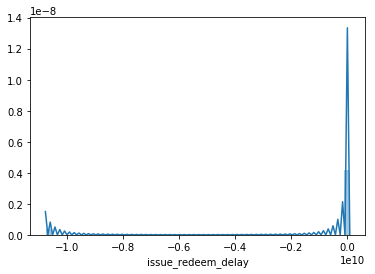

In [192]:
sns.distplot(df_features.issue_redeem_delay)

In [42]:
df_features.head()

,gender_M,gender_F,gender_U,age,first_issue_time,first_redeem_time,issue_redeem_delay,count_all_purschases,count_all_stores,purch_sum__max,...,trn_sum_from_red__max,trn_sum_from_red__std,trn_sum_from_red__std,first_issue_day,first_issue_month,first_issue_year,first_redeem_day,first_redeem_month,first_redeem_year,count
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0,0,1,45,1.501948e+09,1.515094e+09,1.314656e+07,52.0,3.0,700.0,...,0.0,0.0,0.0,5,8,2017,4.0,1.0,2018.0,2.0
000036f903,0,1,0,72,1.491832e+09,1.492951e+09,1.118613e+06,162.0,5.0,306.0,...,0.0,0.0,0.0,10,4,2017,23.0,4.0,2017.0,8.0
000048b7a6,0,1,0,68,1.544881e+09,-9.223372e+09,-1.076825e+10,56.0,2.0,471.0,...,0.0,0.0,0.0,15,12,2018,NaN,NaN,NaN,3.0
000073194a,0,1,0,60,1.495544e+09,1.511522e+09,1.597811e+07,82.0,1.0,564.0,...,21.0,21.0,0.0,23,5,2017,24.0,11.0,2017.0,6.0
00007c7133,0,0,1,67,1.495470e+09,1.546277e+09,5.080682e+07,83.0,2.0,610.0,...,78.0,78.0,0.0,22,5,2017,31.0,12.0,2018.0,5.0


In [39]:
lovely_product_df = (df_purchases.groupby(['client_id','product_id'])['product_id'].agg(['count']
    ).sort_values(by='count', ascending=False).reset_index().drop_duplicates('client_id', keep='first')
                    ).set_index('client_id')['count'].rename('lovely_prod_count')
# lovely_product_df.columns = ['lovely_prod_count']

df_features = df_features.join(lovely_product_df)

In [20]:
indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

model=GradientBoostingClassifier()
X_train=df_features.loc[indices_learn, :].fillna(0).values
treatment_train=df_train.loc[indices_learn, 'treatment_flg'].values
target_train=df_train.loc[indices_learn, 'target'].values
X_test=df_features.loc[indices_valid, :].fillna(0).values

# model, X_train, treatment_train, target_train, X_test = 
X_treatment, y_treatment = X_train[treatment_train == 1, :], target_train[treatment_train == 1]
X_control, y_control = X_train[treatment_train == 0, :], target_train[treatment_train == 0]
model_treatment = clone(model).fit(X_treatment, y_treatment)
model_control = clone(model).fit(X_control, y_control)
eli5.explain_weights(model_control, feature_names = list(df_features.columns))

Weight,Feature
0.5234 ± 0.5467,issue_redeem_delay
0.1677 ± 0.4940,first_redeem_time
0.0780 ± 0.4070,first_issue_time
0.0524 ± 0.2715,age
0.0405 ± 0.2024,count_all_purschases
0.0329 ± 0.1635,purch_sum__std
0.0176 ± 0.1084,count
0.0111 ± 0.1057,purch_sum__max
0.0082 ± 0.1100,first_redeem_day
0.0081 ± 0.0643,trn_sum_from_iss__std


In [23]:
indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

model=GradientBoostingClassifier()
X_train=df_features.loc[indices_learn, :].fillna(0).values
treatment_train=df_train.loc[indices_learn, 'treatment_flg'].values
target_train=df_train.loc[indices_learn, 'target'].values
X_test=df_features.loc[indices_valid, :].fillna(0).values

# model, X_train, treatment_train, target_train, X_test = 
X_treatment, y_treatment = X_train[treatment_train == 1, :], target_train[treatment_train == 1]
X_control, y_control = X_train[treatment_train == 0, :], target_train[treatment_train == 0]
model_treatment = clone(model).fit(X_treatment, y_treatment)
model_control = clone(model).fit(X_control, y_control)
eli5.explain_weights(model_control, feature_names = list(df_features.columns))

Weight,Feature
0.5223 ± 0.5473,issue_redeem_delay
0.1682 ± 0.4939,first_redeem_time
0.0786 ± 0.4070,first_issue_time
0.0521 ± 0.2718,age
0.0405 ± 0.2024,count_all_purschases
0.0332 ± 0.1687,purch_sum__std
0.0176 ± 0.1084,count
0.0113 ± 0.1063,purch_sum__max
0.0082 ± 0.1100,first_redeem_day
0.0081 ± 0.0643,trn_sum_from_iss__std


In [41]:
predict(df_features,print_score=True,
    make_sibmition=True)

Validation score: 0.05352754866712994


In [45]:
def plot_conf_matrix(X,y,model,title):
    y_test, y_pred = make_pred(X,y,model)
    plt.figure()
    grad_ens_conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(grad_ens_conf_matrix, annot=True,  fmt='')
    plt.title(title)

In [ ]:
models = []
models.append(('LC', LogisticRegression()))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('GB' ,GradientBoostingClassifier()))
models.append(('LGBM',LGBMClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('CatBoost', CatBoostClassifier()))
for name, model in models:
    plot_conf_matrix(X,y,model,name)